In [2]:
import json
import numpy as np
import torch
import nltk
import string
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import CrossEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Helper functions

In [3]:
def load_json_file(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

def save_json_file(data, file_path):
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=2)

def load_content_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return {item['FAN']: item['Content'] for item in data}

In [4]:
def extract_text(content_dict, text_type="full"):
    if text_type == "TA":
        title = content_dict.get("title", "")
        abstract = content_dict.get("pa01", "")
        return f"{title} {abstract}".strip()

    elif text_type == "claims":
        return " ".join([v for k, v in content_dict.items() if k.startswith('c-')])

    elif text_type == "tac1":
        title = content_dict.get("title", "")
        abstract = content_dict.get("pa01", "")
        claim1 = ""
        for k, v in content_dict.items():
            if k.startswith('c-'):
                claim1 = v
                break
        return f"{title} {abstract} {claim1}".strip()

    elif text_type == "description":
        return " ".join([v for k, v in content_dict.items() if k.startswith('p')])
    
    elif text_type == "features":
        features = content_dict.get("features", {})
        return " ".join(features.values())

    elif text_type == "full":
        all_text = []
        for item in content_dict:
            all_text.append(item)
        return " ".join(all_text)

    return ""

In [17]:
pre_ranking = load_json_file("shuffled_pre_ranking.json")
queries_list = load_json_file("train_queries.json")
queries_content = load_content_data("queries_content_with_features.json")
documents_content = load_content_data("documents_content_with_features.json")
true_labels_dict = load_json_file("train_gold_mapping.json")

# Filter to only training queries
pre_ranking = {fan: docs for fan, docs in pre_ranking.items() if fan in queries_list}
print(f"Filtered pre-ranking to {len(pre_ranking)} queries")

Filtered pre-ranking to 20 queries


In [6]:
def rerank_cross_encoder(query_text, doc_texts, model, tokenizer, batch_size=4, max_length=512):
    model.eval()
    device = next(model.parameters()).device
    scores = []

    for i in range(0, len(doc_texts), batch_size):
        batch = doc_texts[i:i + batch_size]
        pairs = [(query_text, doc) for doc in batch]

        inputs = tokenizer(
            pairs,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits

            # If it's classification (e.g. 2 labels), use the score for the positive class
            if logits.dim() == 2:
                logits = logits[:, -1]
            else:
                logits = logits.squeeze()

            scores.extend(logits.cpu().tolist())

    return np.argsort(scores)[::-1]

In [7]:
from collections import defaultdict

def reciprocal_rank_fusion(rankings, k=60):
    rrf_scores = defaultdict(float)

    for rank_list in rankings:
        for rank, doc_id in enumerate(rank_list):
            rrf_scores[doc_id] += 1 / (k + rank + 1)

    # Sort by descending RRF score
    fused_ranking = sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)
    return [doc_id for doc_id, _ in fused_ranking]

In [8]:
def extract_top_sentences(description_text, top_n_words=100, max_sentences=5):
    # Split into sentences
    sentences = nltk.sent_tokenize(description_text)

    # Compute TF-IDF over all sentences
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(sentences)
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Get top TF-IDF words overall
    mean_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
    top_indices = mean_scores.argsort()[-top_n_words:]
    top_words = set(feature_names[top_indices])

    # Score sentences by how many top words they include
    def score_sentence(sentence):
        words = sentence.translate(str.maketrans('', '', string.punctuation)).lower().split()
        return sum(1 for word in words if word in top_words)

    ranked = sorted(sentences, key=score_sentence, reverse=True)
    return " ".join(ranked[:max_sentences])  # or adjust for length

In [9]:
def recall_at_k(true_items, predicted_items, k=10):
    """
    Calculate recall at k for a single query.
    
    Parameters:
    true_items (list): List of true relevant items
    predicted_items (list): List of predicted items (ranked)
    k (int): Number of top items to consider
    
    Returns:
    float: Recall@k value between 0 and 1
    """
    if not true_items:
        return 0.0  # No relevant items to recall
    
    # Get the top k predicted items
    top_k_items = predicted_items[:k]
    
    # Count the number of true items in the top k predictions
    relevant_in_top_k = sum(1 for item in top_k_items if item in true_items)
    
    # Calculate recall: (relevant items in top k) / (total relevant items)
    return relevant_in_top_k / len(true_items)


def average_precision(true_items, predicted_items):
    """
    Calculate average precision for a single query.
    
    Parameters:
    true_items (list): List of true relevant items
    predicted_items (list): List of predicted items (ranked)
    
    Returns:
    float: Average precision value between 0 and 1
    """
    if not true_items or not predicted_items:
        return 0.0
    
    # Track number of relevant items seen and running sum of precision values
    relevant_count = 0
    precision_sum = 0.0
    
    # Calculate precision at each position where a relevant item is found
    for i, item in enumerate(predicted_items):
        position = i + 1  # 1-indexed position
        
        if item in true_items:
            relevant_count += 1
            # Precision at this position = relevant items seen / position
            precision_at_position = relevant_count / position
            precision_sum += precision_at_position
    
    # Average precision = sum of precision values / total relevant items
    total_relevant = len(true_items)
    return precision_sum / total_relevant if total_relevant > 0 else 0.0


def mean_average_precision(true_items_list, predicted_items_list):
    """
    Calculate mean average precision (MAP) across multiple queries.
    
    Parameters:
    true_items_list (list of lists): List of true relevant items for each query
    predicted_items_list (list of lists): List of predicted items for each query
    
    Returns:
    float: MAP value between 0 and 1
    """
    if len(true_items_list) != len(predicted_items_list):
        raise ValueError("Number of true item lists must match number of predicted item lists")
    
    if not true_items_list:
        return 0.0  # No data provided
    
    # Calculate average precision for each query
    aps = [average_precision(true_items, predicted_items) 
           for true_items, predicted_items in zip(true_items_list, predicted_items_list)]
    
    # Return mean average precision
    return sum(aps) / len(aps)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer_tac1 = AutoTokenizer.from_pretrained("cross-encoder/stsb-roberta-base")
model_tac1 = AutoModelForSequenceClassification.from_pretrained("cross-encoder/stsb-roberta-base").to(device)

# Cross-encoder for Features and Description
tokenizer_stsb = AutoTokenizer.from_pretrained("cross-encoder/stsb-roberta-base")
model_stsb = AutoModelForSequenceClassification.from_pretrained("cross-encoder/stsb-roberta-base").to(device)

from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load TinyBERT cross-encoder (fine-tuned on MS MARCO)
desc_model_name = "cross-encoder/stsb-roberta-base"
desc_tokenizer = AutoTokenizer.from_pretrained(desc_model_name)
desc_model = AutoModelForSequenceClassification.from_pretrained(desc_model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# Bi-encoder for claims
model_sbert = SentenceTransformer("AI-Growth-Lab/PatentSBERTa").to(device)

In [ ]:
re_ranked = {}
rankings_by_section = {"tac1": {}, "claims": {}, "features": {}, "desc": {}}

for query_id, doc_ids in tqdm(pre_ranking.items(), desc="Re-ranking queries"):
    if query_id not in queries_content:
        continue

    section_rankings = []

    # ───── TAC1 (Cross-Encoder) ─────
    query_text = extract_text(queries_content[query_id], "tac1")
    doc_texts, valid_doc_ids = [], []

    for doc_id in doc_ids:
        doc_text = extract_text(documents_content.get(doc_id, {}), "tac1")
        if doc_text.strip():
            doc_texts.append(doc_text)
            valid_doc_ids.append(doc_id)

    if doc_texts:
        sorted_indices = rerank_cross_encoder(query_text, doc_texts, model_tac1, tokenizer_tac1)
        ranked_docs = [valid_doc_ids[i] for i in sorted_indices]
        section_rankings.append(ranked_docs)
        rankings_by_section["tac1"][query_id] = ranked_docs

    # ───── Claims (PatentSBERTa Bi-Encoder) ─────
    query_claims = extract_text(queries_content[query_id], "claims")
    doc_claims, valid_ids_claims = [], []

    for doc_id in doc_ids:
        text = extract_text(documents_content.get(doc_id, {}), "claims")
        if text:
            doc_claims.append(text)
            valid_ids_claims.append(doc_id)

    if doc_claims:
        sorted_indices = rerank_cross_encoder(query_claims, doc_claims, model_tac1, tokenizer_tac1)
        ranked_docs = [valid_doc_ids[i] for i in sorted_indices]
        section_rankings.append(ranked_docs)
        rankings_by_section["tac1"][query_id] = ranked_docs

    # ───── Features (STSB Cross-Encoder) ─────
    query_feat = extract_text(queries_content[query_id], "features")
    doc_feat, valid_ids_feat = [], []

    for doc_id in doc_ids:
        feat = extract_text(documents_content.get(doc_id, {}), "features")
        if feat.strip():
            doc_feat.append(feat)
            valid_ids_feat.append(doc_id)

    if doc_feat:
        sorted_indices = rerank_cross_encoder(query_feat, doc_feat, model_stsb, tokenizer_stsb)
        ranked_feats = [valid_ids_feat[i] for i in sorted_indices]
        section_rankings.append(ranked_feats)
        rankings_by_section["features"][query_id] = ranked_feats

    # ───── Description (TinyBERT Cross-Encoder) ─────
    desc = extract_text(queries_content[query_id], "description")
    query_desc = extract_top_sentences(desc)  # Optional: truncate to informative part
    doc_desc = []
    valid_ids_desc = []

    for doc_id in doc_ids:
        d = extract_text(documents_content.get(doc_id, {}), "description")
        short = extract_top_sentences(d)
        if short:
            doc_desc.append(short)
            valid_ids_desc.append(doc_id)

    if doc_desc:
        query_emb = model_sbert.encode([query_desc], convert_to_tensor=True)
        doc_embs = model_sbert.encode(doc_desc, convert_to_tensor=True)
        scores = util.cos_sim(query_emb, doc_embs)[0].cpu().numpy()
        indices = np.argsort(scores)[::-1]
        ranked_claims = [valid_ids_claims[i] for i in indices]
        section_rankings.append(ranked_claims)
        rankings_by_section["claims"][query_id] = ranked_claims

    # ───── Final Fusion ─────
for query_id in query_ids:
    section_lists = []

    for section in rankings_by_section:
        section_ranking = rankings_by_section[section].get(query_id, [])
        section_lists.append(section_ranking)

    re_ranked[query_id] = reciprocal_rank_fusion(section_lists, k=60)

In [ ]:
# Save results
save_json_file(re_ranked, "predictions2.json")
print("Saved reranked results to predictions2.json")

In [20]:
import json

# Save rankings by section
for section, rankings in rankings_by_section.items():
    with open(f"section_rankings_{section}.json", "w") as f:
        json.dump(rankings, f, indent=2)

In [80]:
import json

# List of sections you used
sections = ["tac1", "claims", "features", "desc"]

# Dictionary to hold loaded rankings
loaded_rankings_by_section = {}

# Load each section's ranking from its JSON file
for section in sections:
    with open(f"section_rankings_{section}.json", "r") as f:
        loaded_rankings_by_section[section] = json.load(f)

# Now you can access like:
# loaded_rankings_by_section["claims"]["query_id"]
# loaded_rankings_by_section["features"]["query_id"]

In [21]:
def evaluate_rrf_from_saved(rankings_by_section, gold_dict, k=60):
    re_ranked = {}
    predictions, true = [], []

    # Assume all section keys have the same query_ids
    section_names = list(rankings_by_section.keys())
    query_ids = rankings_by_section[section_names[0]].keys()

    for query_id in query_ids:
        section_lists = []

        for section in section_names:
            section_ranking = rankings_by_section[section].get(query_id, [])
            section_lists.append(section_ranking)

        fused = reciprocal_rank_fusion(section_lists, k=k)
        re_ranked[query_id] = fused
        predictions.append(fused)
        true.append(gold_dict.get(query_id, []))

    # Compute metrics
    map_score = mean_average_precision(true, predictions)
    recall_10 = np.mean([recall_at_k(t, p, k=10) for t, p in zip(true, predictions)])

    return map_score, recall_10, re_ranked

In [22]:
best_k = None
best_map = -1
results = []

for k_val in range(10, 100, 10):
    map_score, recall_10, _ = evaluate_rrf_from_saved(rankings_by_section, true_labels_dict, k=k_val)
    results.append((k_val, map_score, recall_10))

    print(f"k={k_val:3d} | MAP={map_score:.4f} | Recall@10={recall_10:.4f}")

    if map_score > best_map:
        best_map = map_score
        best_k = k_val


k= 10 | MAP=0.2906 | Recall@10=0.4776
k= 20 | MAP=0.2820 | Recall@10=0.4651
k= 30 | MAP=0.2820 | Recall@10=0.4776
k= 40 | MAP=0.2816 | Recall@10=0.4776
k= 50 | MAP=0.2810 | Recall@10=0.4610
k= 60 | MAP=0.2801 | Recall@10=0.4610
k= 70 | MAP=0.2834 | Recall@10=0.4610
k= 80 | MAP=0.2834 | Recall@10=0.4610
k= 90 | MAP=0.2834 | Recall@10=0.4610


In [23]:
def weighted_rrf(rankings, weights, k=60):
    from collections import defaultdict
    assert len(rankings) == len(weights), "Each ranking must have a corresponding weight"

    scores = defaultdict(float)

    for weight, ranking in zip(weights, rankings):
        for rank, doc_id in enumerate(ranking):
            scores[doc_id] += weight / (k + rank)

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [doc_id for doc_id, _ in ranked]

def get_rankings_and_labels(rankings_by_section, gold_dict, query_ids, weights, k=60):
    section_names = list(rankings_by_section.keys())

    predictions = []
    true = []

    for query_id in query_ids:
        section_rankings = [rankings_by_section[section].get(query_id, []) for section in section_names]
        fused = weighted_rrf(section_rankings, weights, k)
        predictions.append(fused)
        true.append(gold_dict.get(query_id, []))

    return true, predictions


def evaluate_weights_cv(rankings_by_section, gold_dict, query_ids, weights, k=60, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    section_names = list(rankings_by_section.keys())

    all_scores = []

    for train_idx, val_idx in kf.split(query_ids):
        train_ids = [query_ids[i] for i in train_idx]
        val_ids = [query_ids[i] for i in val_idx]

        # Use weights to rerank
        true, preds = get_rankings_and_labels(rankings_by_section, gold_dict, val_ids, weights, k)

        # Evaluate MAP
        map_score = mean_average_precision(true, preds)
        all_scores.append(map_score)

    return np.mean(all_scores)

def random_search_weight_optimization(rankings_by_section, gold_dict, query_ids, n_trials=10, k=60):
    best_score = -1
    best_weights = None
    section_count = len(rankings_by_section)

    for _ in range(n_trials):
        weights = np.random.dirichlet(np.ones(section_count))  # generate weights that sum to 1
        score = evaluate_weights_cv(rankings_by_section, gold_dict, query_ids, weights, k=k)

        if score > best_score:
            best_score = score
            best_weights = weights

    return best_weights, best_score

In [24]:
query_ids = list(rankings_by_section["tac1"].keys())
best_weights, best_score = random_search_weight_optimization(
    rankings_by_section=rankings_by_section,
    gold_dict=true_labels_dict,
    query_ids=query_ids,
    n_trials=100,
    k=60
)

print("Best Weights:", best_weights)
print("Cross-validated MAP:", best_score)

Best Weights: [0.32658191 0.1850977  0.4883204 ]
Cross-validated MAP: 0.2993352047149172


query_ids = list(rankings_by_section["tac1"].keys())
best_weights, best_score = random_search_weight_optimization(
    rankings_by_section=rankings_by_section,
    gold_dict=true_labels_dict,
    query_ids=query_ids,
    n_trials=100,
    k=60
)

print("Best Weights:", best_weights)
print("Cross-validated MAP:", best_score)

Best Weights: [0.19436025 0.20876117 0.56151793 0.03536065]
Cross-validated MAP: 0.2633074309640015

In [12]:
pre_ranking = load_json_file("shuffled_pre_ranking.json")
queries_list_test = load_json_file("test_queries.json")
pre_ranking_test = {fan: docs for fan, docs in pre_ranking.items() if fan in queries_list_test}
print(f"Filtered pre-ranking to {len(pre_ranking_test)} queries")

Filtered pre-ranking to 10 queries


In [ ]:
re_ranked = {}
rankings_by_section_test = {"tac1": {}, "claims": {}, "features": {}, "desc": {}}

for query_id, doc_ids in tqdm(pre_ranking_test.items(), desc="Re-ranking queries"):
    if query_id not in queries_content:
        continue

    section_rankings = []

    # ───── TAC1 (Cross-Encoder) ─────
    query_text = extract_text(queries_content[query_id], "tac1")
    doc_texts, valid_doc_ids = [], []

    for doc_id in doc_ids:
        doc_text = extract_text(documents_content.get(doc_id, {}), "tac1")
        if doc_text.strip():
            doc_texts.append(doc_text)
            valid_doc_ids.append(doc_id)

    if doc_texts:
        sorted_indices = rerank_cross_encoder(query_text, doc_texts, model_tac1, tokenizer_tac1)
        ranked_docs = [valid_doc_ids[i] for i in sorted_indices]
        section_rankings.append(ranked_docs)
        rankings_by_section_test["tac1"][query_id] = ranked_docs

    # ───── Claims (PatentSBERTa Bi-Encoder) ─────
    query_claims = extract_text(queries_content[query_id], "claims")
    doc_claims, valid_ids_claims = [], []

    for doc_id in doc_ids:
        text = extract_text(documents_content.get(doc_id, {}), "claims")
        if text:
            doc_claims.append(text)
            valid_ids_claims.append(doc_id)

    if doc_claims:
        query_emb = model_sbert.encode([query_claims], convert_to_tensor=True)
        doc_embs = model_sbert.encode(doc_claims, convert_to_tensor=True)
        scores = util.cos_sim(query_emb, doc_embs)[0].cpu().numpy()
        indices = np.argsort(scores)[::-1]
        ranked_claims = [valid_ids_claims[i] for i in indices]
        section_rankings.append(ranked_claims)
        rankings_by_section_test["claims"][query_id] = ranked_claims

    # ───── Features (STSB Cross-Encoder) ─────
    query_feat = extract_text(queries_content[query_id], "features")
    doc_feat, valid_ids_feat = [], []

    for doc_id in doc_ids:
        feat = extract_text(documents_content.get(doc_id, {}), "features")
        if feat.strip():
            doc_feat.append(feat)
            valid_ids_feat.append(doc_id)

    if doc_feat:
        sorted_indices = rerank_cross_encoder(query_feat, doc_feat, model_stsb, tokenizer_stsb)
        ranked_feats = [valid_ids_feat[i] for i in sorted_indices]
        section_rankings.append(ranked_feats)
        rankings_by_section_test["features"][query_id] = ranked_feats

    # ───── Description (TinyBERT Cross-Encoder) ─────
    desc = extract_text(queries_content[query_id], "description")
    query_desc = extract_top_sentences(desc)  # Optional: truncate to informative part
    doc_desc = []
    valid_ids_desc = []

    for doc_id in doc_ids:
        d = extract_text(documents_content.get(doc_id, {}), "description")
        short = extract_top_sentences(d)
        if short:
            doc_desc.append(short)
            valid_ids_desc.append(doc_id)

    if doc_desc:
        sorted_indices = rerank_cross_encoder(
            query_desc, doc_desc, desc_model, desc_tokenizer
        )
        ranked_desc = [valid_ids_desc[i] for i in sorted_indices]
        section_rankings.append(ranked_desc)
        rankings_by_section_test["desc"][query_id] = ranked_desc

    # ───── Final Fusion ─────
for query_id in query_ids:
    section_lists = []

    for section in rankings_by_section:
        section_ranking = rankings_by_section[section].get(query_id, [])
        section_lists.append(section_ranking)

    re_ranked[query_id] = weighted_rrf(section_lists, best_weights, k=60)

In [ ]:
# Save results
save_json_file(re_ranked, "prediction2.json")
print("Saved reranked results to prediction2.json")

In [9]:
re_ranked_tac = {}

for query_id, doc_ids in tqdm(pre_ranking_test.items(), desc="Re-ranking queries"):
    if query_id not in queries_content:
        continue

    query_text = extract_text(queries_content[query_id], text_type="tac1")
    doc_texts = []
    valid_doc_ids = []

    for doc_id in doc_ids:
        if doc_id not in documents_content:
            continue
        doc_text = extract_text(documents_content[doc_id], text_type="tac1")
        if doc_text.strip():
            valid_doc_ids.append(doc_id)
            doc_texts.append(doc_text)

    if not doc_texts:
        re_ranked_tac[query_id] = []
        continue

    sorted_indices = rerank_cross_encoder(query_text, doc_texts, model, tokenizer)
    re_ranked_tac[query_id] = [valid_doc_ids[i] for i in sorted_indices]

Re-ranking queries: 100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


In [12]:
from sentence_transformers import SentenceTransformer, util

# Load BGE model
bge_model = SentenceTransformer("BAAI/bge-base-en-v1.5")

def rerank_with_bge(query_text, doc_texts, model):
    query_emb = model.encode(query_text, convert_to_tensor=True)
    doc_embs = model.encode(doc_texts, convert_to_tensor=True)

    # Compute cosine similarity
    scores = util.cos_sim(query_emb, doc_embs)[0].cpu().numpy()
    return np.argsort(scores)[::-1]  # Sort by similarity (descending)

In [ ]:
re_ranked_tac = {}

for query_id, doc_ids in tqdm(pre_ranking.items(), desc="Re-ranking queries"):
    if query_id not in queries_content:
        continue

    query_text = extract_text(queries_content[query_id], text_type="features")
    if not query_text:
        re_ranked_tac[query_id] = []
        continue

    doc_texts = []
    valid_doc_ids = []

    for doc_id in doc_ids:
        if doc_id not in documents_content:
            continue
        doc_text = extract_text(documents_content[doc_id], text_type="features")
        if doc_text.strip():
            valid_doc_ids.append(doc_id)
            doc_texts.append(doc_text)

    if not doc_texts:
        re_ranked_tac[query_id] = []
        continue

    sorted_indices = rerank_with_bge(query_text, doc_texts, bge_model)
    re_ranked_tac[query_id] = [valid_doc_ids[i] for i in sorted_indices]

In [14]:
from sentence_transformers import SentenceTransformer, util
import torch
import numpy as np

# Load Snowflake Arctic Embed (bi-encoder)
bge_model = SentenceTransformer("Snowflake/snowflake-arctic-embed-l-v2.0")
bge_model = bge_model.to("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
re_ranked_tac = {}

for query_id, doc_ids in tqdm(pre_ranking.items(), desc="Re-ranking queries"):
    if query_id not in queries_content:
        continue

    query_text = extract_text(queries_content[query_id], text_type="features")
    if not query_text:
        re_ranked_tac[query_id] = []
        continue

    doc_texts = []
    valid_doc_ids = []

    for doc_id in doc_ids:
        if doc_id not in documents_content:
            continue
        doc_text = extract_text(documents_content[doc_id], text_type="features")
        if doc_text.strip():
            valid_doc_ids.append(doc_id)
            doc_texts.append(doc_text)

    if not doc_texts:
        re_ranked_tac[query_id] = []
        continue

    # Encode query and documents using Snowflake Arctic
    query_emb = bge_model.encode([query_text], convert_to_tensor=True, normalize_embeddings=True)
    doc_embs = bge_model.encode(doc_texts, convert_to_tensor=True, normalize_embeddings=True)

    # Compute cosine similarity
    scores = util.cos_sim(query_emb, doc_embs)[0].cpu().numpy()

    # Get sorted document indices by similarity
    sorted_indices = np.argsort(scores)[::-1]
    re_ranked_tac[query_id] = [valid_doc_ids[i] for i in sorted_indices]

Re-ranking queries: 100%|██████████| 20/20 [26:40<00:00, 80.01s/it]


In [13]:
from sentence_transformers import SentenceTransformer, util
import torch
import numpy as np

arctic_model_name = "Snowflake/snowflake-arctic-embed-l-v2.0"
tokenizer = AutoTokenizer.from_pretrained(arctic_model_name)
model = AutoModel.from_pretrained(arctic_model_name).to("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
def encode_arctic(texts, tokenizer, model):
    encoded = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(model.device)
    with torch.no_grad():
        model_output = model(**encoded)
        embeddings = model_output.last_hidden_state[:, 0]  # Use CLS token
        embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
    return embeddings

# ---- Reciprocal Rank Fusion ----
def reciprocal_rank_fusion(rank_lists, k=60):
    scores = {}
    for rank_list in rank_lists:
        for rank, doc_id in enumerate(rank_list):
            scores[doc_id] = scores.get(doc_id, 0) + 1.0 / (k + rank + 1)
    return sorted(scores, key=scores.get, reverse=True)

In [18]:
sections = ["tac1", "claims", "features"]  # Exclude "description"
re_ranked = {}
rankings_by_section = {section: {} for section in sections}

for query_id, doc_ids in tqdm(pre_ranking.items(), desc="Re-ranking queries"):
    if query_id not in queries_content:
        continue

    section_rankings = []

    for section in sections:
        query_text = extract_text(queries_content[query_id], text_type=section)
        if not query_text.strip():
            continue

        doc_texts = []
        valid_doc_ids = []

        for doc_id in doc_ids:
            if doc_id not in documents_content:
                continue

            doc_text = extract_text(documents_content[doc_id], text_type=section)
            if doc_text.strip():
                valid_doc_ids.append(doc_id)
                doc_texts.append(doc_text)

        if not doc_texts:
            continue

        query_emb = encode_arctic([query_text], tokenizer, model)
        doc_embs = encode_arctic(doc_texts, tokenizer, model)
        cos_scores = util.cos_sim(query_emb, doc_embs)[0].cpu().numpy()
        indices = np.argsort(cos_scores)[::-1]
        ranked = [valid_doc_ids[i] for i in indices]

        section_rankings.append(ranked)
        rankings_by_section[section][query_id] = ranked

    if section_rankings:
        fused = reciprocal_rank_fusion(section_rankings)
        re_ranked[query_id] = fused
    else:
        re_ranked[query_id] = []

Re-ranking queries: 100%|██████████| 20/20 [7:20:44<00:00, 1322.21s/it]  


In [33]:
# Save results
save_json_file(re_ranked, "predictions2.json")
print("Saved reranked results to predictions2.json")

Saved reranked results to predictions2.json


In [15]:
sections = ["tac1", "claims", "features"]  # Exclude "description"
re_ranked = {}
rankings_by_section = {section: {} for section in sections}

for query_id, doc_ids in tqdm(pre_ranking_test.items(), desc="Re-ranking queries"):
    if query_id not in queries_content:
        continue

    section_rankings = []

    for section in sections:
        query_text = extract_text(queries_content[query_id], text_type=section)
        if not query_text.strip():
            continue

        doc_texts = []
        valid_doc_ids = []

        for doc_id in doc_ids:
            if doc_id not in documents_content:
                continue

            doc_text = extract_text(documents_content[doc_id], text_type=section)
            if doc_text.strip():
                valid_doc_ids.append(doc_id)
                doc_texts.append(doc_text)

        if not doc_texts:
            continue

        query_emb = encode_arctic([query_text], tokenizer, model)
        doc_embs = encode_arctic(doc_texts, tokenizer, model)
        cos_scores = util.cos_sim(query_emb, doc_embs)[0].cpu().numpy()
        indices = np.argsort(cos_scores)[::-1]
        ranked = [valid_doc_ids[i] for i in indices]

        section_rankings.append(ranked)
        rankings_by_section[section][query_id] = ranked

    if section_rankings:
        fused = reciprocal_rank_fusion(section_rankings)
        re_ranked[query_id] = fused
    else:
        re_ranked[query_id] = []

Re-ranking queries: 100%|██████████| 10/10 [2:17:32<00:00, 825.25s/it]  


In [30]:
# Save results
save_json_file(re_ranked, "prediction2.json")
print("Saved reranked results to prediction2.json")

Saved reranked results to prediction2.json


In [29]:
sections = ["tac1", "features"]  # Exclude "description"
re_ranked = {}
rankings_by_section = {section: {} for section in sections}

for query_id, doc_ids in tqdm(pre_ranking_test.items(), desc="Re-ranking queries"):
    if query_id not in queries_content:
        continue

    section_rankings = []

    for section in sections:
        query_text = extract_text(queries_content[query_id], text_type=section)
        if not query_text.strip():
            continue

        doc_texts = []
        valid_doc_ids = []

        for doc_id in doc_ids:
            if doc_id not in documents_content:
                continue

            doc_text = extract_text(documents_content[doc_id], text_type=section)
            if doc_text.strip():
                valid_doc_ids.append(doc_id)
                doc_texts.append(doc_text)

        if not doc_texts:
            continue

        query_emb = encode_arctic([query_text], tokenizer, model)
        doc_embs = encode_arctic(doc_texts, tokenizer, model)
        cos_scores = util.cos_sim(query_emb, doc_embs)[0].cpu().numpy()
        indices = np.argsort(cos_scores)[::-1]
        ranked = [valid_doc_ids[i] for i in indices]

        section_rankings.append(ranked)
        rankings_by_section[section][query_id] = ranked

    if section_rankings:
        fused = reciprocal_rank_fusion(section_rankings)
        re_ranked[query_id] = fused
    else:
        re_ranked[query_id] = []

Re-ranking queries: 100%|██████████| 10/10 [24:23<00:00, 146.40s/it]


In [34]:
import platform

if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

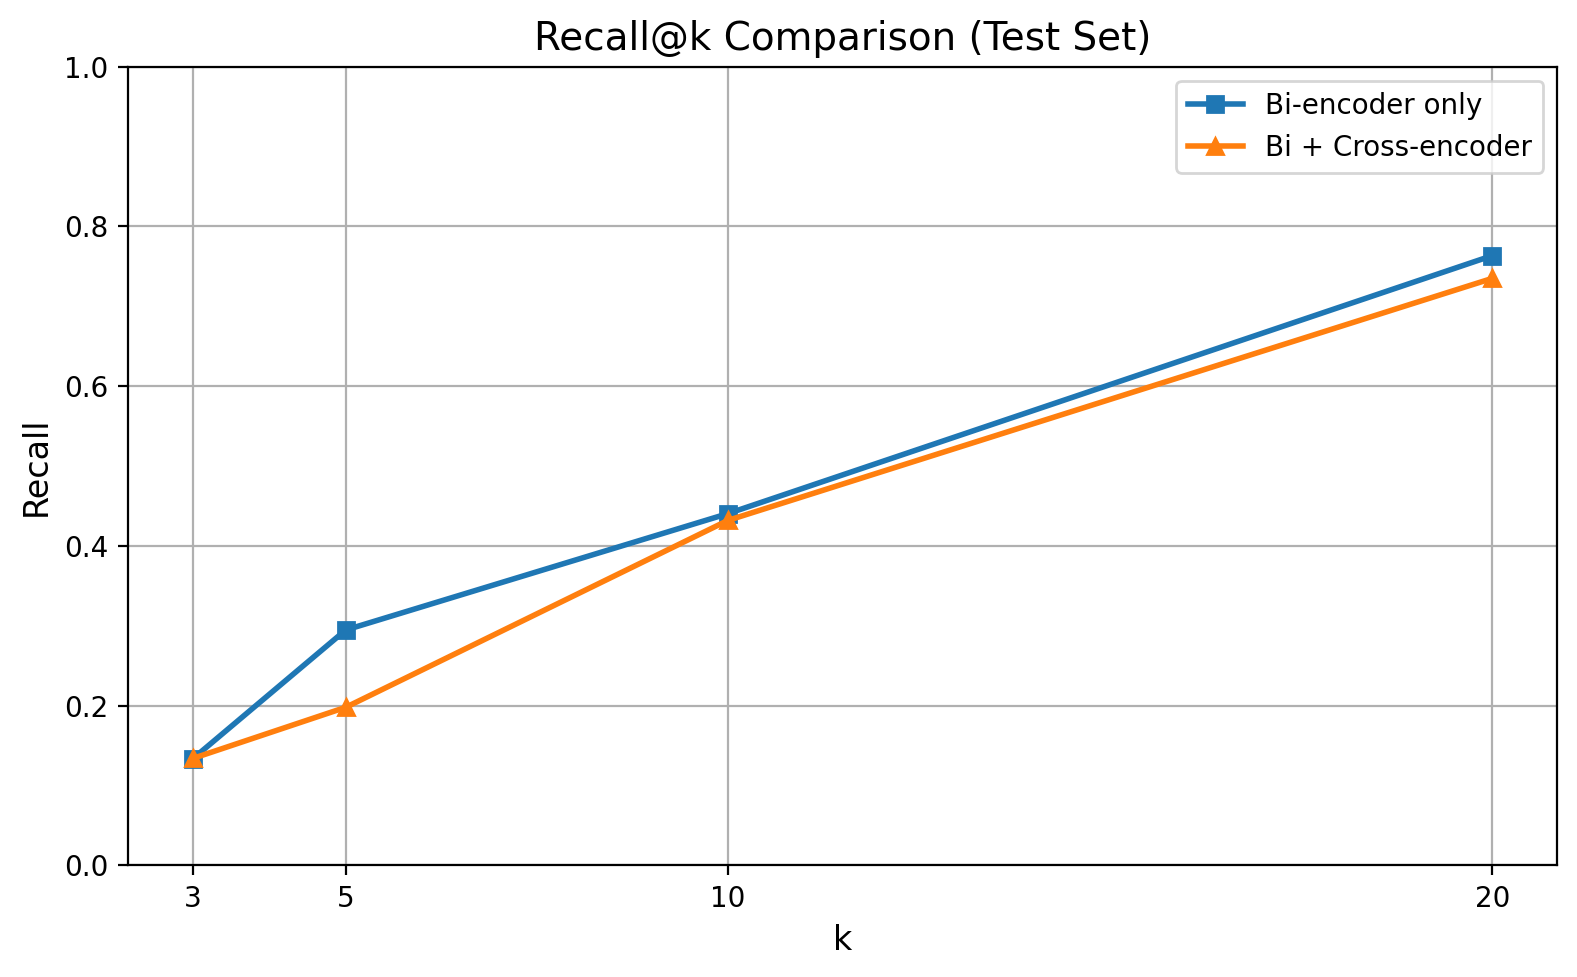

In [39]:
import matplotlib.pyplot as plt

# Recall values at different ks
ks = [3, 5, 10, 20]

# Bi-encoder only (test set)
bi_encoder = [0.1337, 0.2948, 0.4405, 0.7635]

# Bi + Cross encoder (test set)
cross_bi_encoder = [0.134, 0.198, 0.432, 0.735]

# Plotting
plt.figure(figsize=(8, 5))
#plt.plot(ks, pre_ranking, marker='o', label="Pre-ranking", linewidth=2)
plt.plot(ks, bi_encoder, marker='s', label="Bi-encoder only", linewidth=2)
plt.plot(ks, cross_bi_encoder, marker='^', label="Bi + Cross-encoder", linewidth=2)

plt.title("Recall@k Comparison (Test Set)", fontsize=14)
plt.xlabel("k", fontsize=12)
plt.ylabel("Recall", fontsize=12)
plt.xticks(ks)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

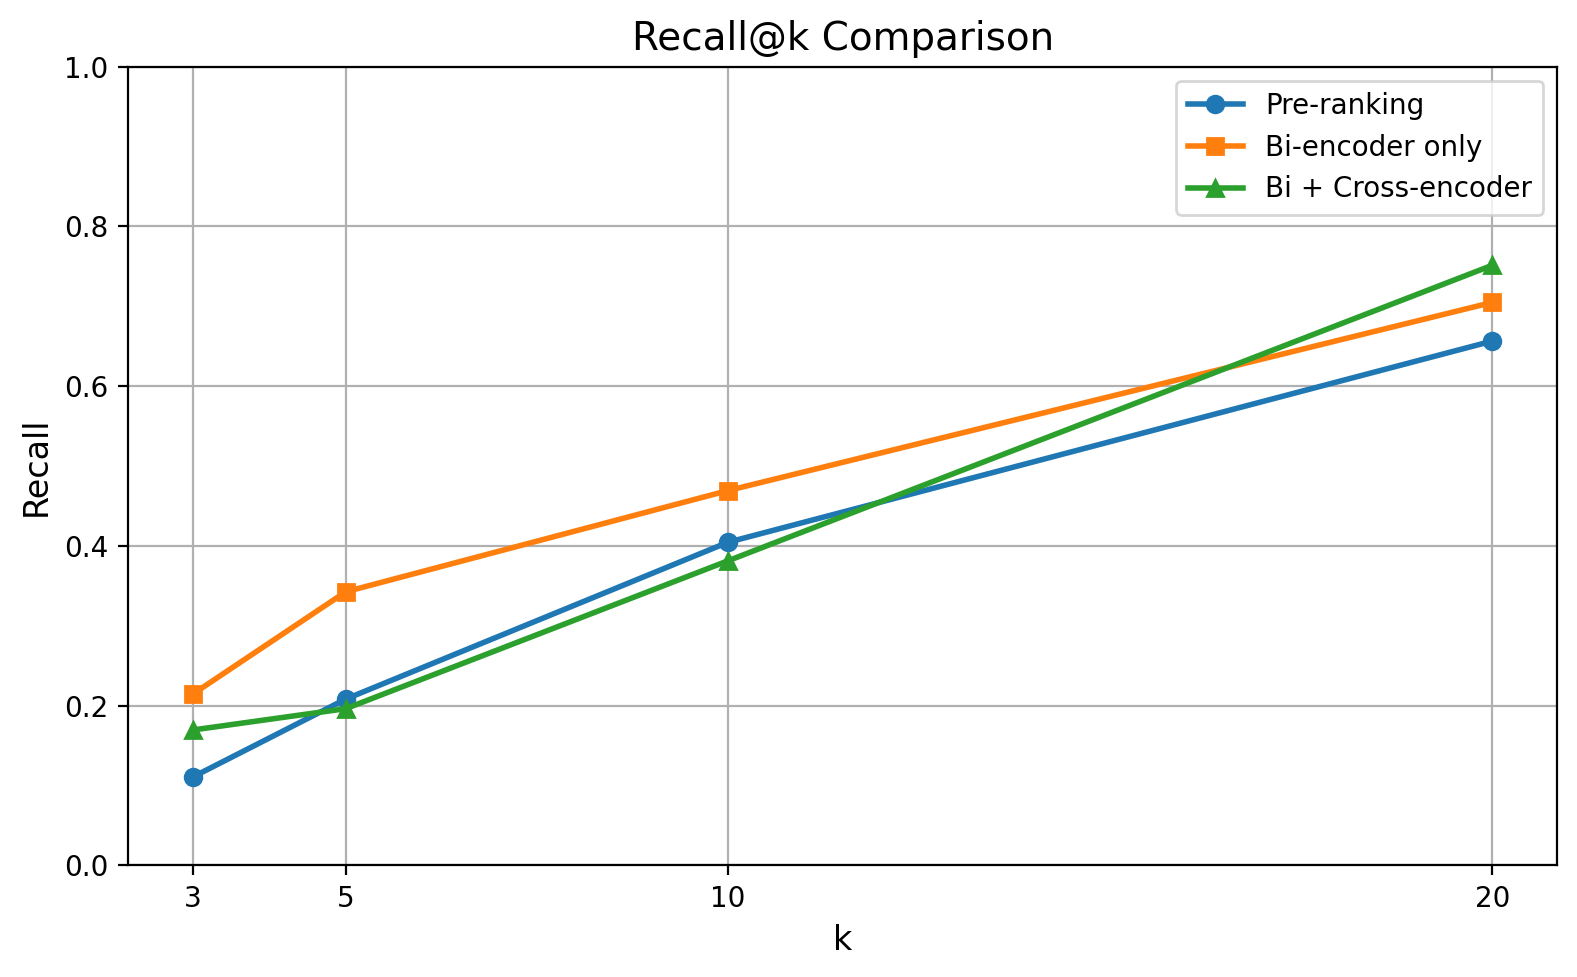

In [37]:
import matplotlib.pyplot as plt

# Recall values at different ks
ks = [3, 5, 10, 20]

# Pre-ranking (training queries)
pre_ranking = [0.1108, 0.2083, 0.4046, 0.6565]

# Bi-encoder only (test set)
bi_encoder = [0.2146, 0.3426, 0.4693, 0.7049]

# Bi + Cross encoder (test set)
cross_bi_encoder = [0.1696, 0.1963, 0.3814, 0.7514]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(ks, pre_ranking, marker='o', label="Pre-ranking", linewidth=2)
plt.plot(ks, bi_encoder, marker='s', label="Bi-encoder only", linewidth=2)
plt.plot(ks, cross_bi_encoder, marker='^', label="Bi + Cross-encoder", linewidth=2)

plt.title("Recall@k Comparison", fontsize=14)
plt.xlabel("k", fontsize=12)
plt.ylabel("Recall", fontsize=12)
plt.xticks(ks)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()